# Exploring Control - Linear Pathway

## Preliminaries

In [1]:
import control as c
from symmathSBML.symmath_sbml import SymmathSBML
import symmathSBML.constants as cn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as s
import tellurium as te

import os

## Antimony Model

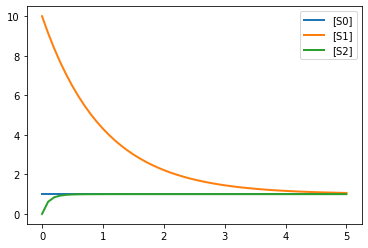

In [46]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
MODEL = """
-> S0; 1
S0 -> S1; S0
S1 -> S2; k2*S1
S2 -> $S3; k3*S2*S1

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
ROADRUNNER = te.loada(MODEL)
ROADRUNNER.plot(ROADRUNNER.simulate())

In [45]:
ROADRUNNER.reset()
jacobian_mat = ROADRUNNER.getFullJacobian()
jacobian_mat

      S0, S1,  S2
S0 [[ -1,  0,   0],
S1  [  1, -1,   0],
S2  [  0,  1, -10]]

In [38]:
SYMMATH = SymmathSBML(MODEL)

In [39]:
SYMMATH.namespace_dct.keys()

dict_keys(['k0', 'k2', 'k3', 'k1', 'k4', 'S0', 'S1', 'S2', 'S3', 'J0', 'J1', 'J2', '__builtins__'])

## System properties of Model

In [40]:
SYMMATH.state_svec

Matrix([
[S0],
[S1]])

**Issues**
1. Why doesn't this include S3, S4?

In [41]:
SYMMATH.substitute(expression=SYMMATH.state_epr_jacobian_smat)

Matrix([
[1.0, -1.0],
[  0,  1.0]])

## Accuracy of Linear Model

In [6]:
# Construct the elements of a system
symmath = SYMMATH.copy()
sys = symmath.mkStateSpace()
X0 = symmath.mkInitialState()

In [7]:
sys

StateSpace(array([[ -1.,   0.,   0.],
       [  1., -10.,   0.],
       [  0.,  10.,   0.]]), array([[0.],
       [0.],
       [0.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

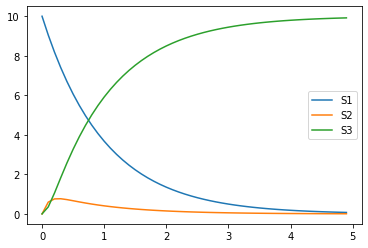

In [8]:
num_species = len(X0)
times = [0.1*n for n in range(50)]
_, ax = plt.subplots(1)
T, yout = c.forced_response(sys, T=times, X0=X0)
for idx in range(num_species):
    ax.plot(T, yout[idx])
plt.legend(symmath.species_names)

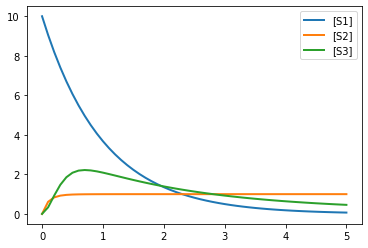

In [9]:
symmath.roadrunner.reset()
data = symmath.roadrunner.simulate(0, 5)
symmath.roadrunner.plot(data)

# Controllability

In [10]:
B = np.array([1, 0, 0])
B = np.reshape(B, (3, 1))
B

array([[1],
       [0],
       [0]])

In [11]:
sys1 = c.StateSpace(sys.A, B, sys.C, sys.D)
sys1

StateSpace(array([[ -1.,   0.,   0.],
       [  1., -10.,   0.],
       [  0.,  10.,   0.]]), array([[1.],
       [0.],
       [0.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

In [12]:
np.linalg.matrix_rank(c.ctrb(sys1.A, sys1.B))

3

In [13]:
np.linalg.eig(sys.A)

(array([  0., -10.,  -1.]),
 array([[ 0.        ,  0.        ,  0.66712438],
        [ 0.        ,  0.70710678,  0.07412493],
        [ 1.        , -0.70710678, -0.74124932]]))

## Issues
1. Many models wouldn't load in symmathSBML
1. Seems that state includes some elements that are not species, BCK2
1. Why is there a difference between the length of the state_vec and the length of species_names?
1. Need getCurrentState